<a href="https://colab.research.google.com/github/TamaVux/PdM/blob/main/Pronostia/Pronostia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The whole dataset is big ($10^6$ points) and only for a small number of bearing
So the model will build on whole 1 (or 2) dataset and will apply to the rest of the units


# SETUP

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#For model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# # For EDA
# !pip install ydata-profiling
# import ydata_profiling as pdpf

# FOLDER PATHS

In [3]:
DRIVE_PATHS = '/content/drive/MyDrive/ColabProjects'
PROJECT_NAME = 'PdM'
DRIVE_FOLDERS = {
    'DATASET': os.path.join(DRIVE_PATHS,PROJECT_NAME,'dataset'),
    'MODEL': os.path.join(DRIVE_PATHS,PROJECT_NAME,'model'),
    'PRONOSTIA': os.path.join(DRIVE_PATHS,PROJECT_NAME,'dataset','Pronostia'),
    'RESULTS': os.path.join(DRIVE_PATHS,PROJECT_NAME,'results')
}

project tag

In [4]:
PRONOSTIA = {
    'SAVE_MODEL': os.path.join(DRIVE_FOLDERS['MODEL'],'Pronostia'),
    'SAVE_RESULTS': os.path.join(DRIVE_FOLDERS['RESULTS'],'Pronostia'),
    'SAVE_DATA': os.path.join(DRIVE_FOLDERS['PRONOSTIA'],'features'),
}

In [5]:
for path in DRIVE_FOLDERS.values() :
    if not os.path.exists(path):
        if os.name == 'posix':
          print('create: {}'.format(path))
          !mkdir -p {path}
        if os.name == 'nt':
          print('create: {}'.format(path))
          !mkdir {path}

for path in PRONOSTIA.values() :
    if not os.path.exists(path):
        if os.name == 'posix':
          print('create: {}'.format(path))
          !mkdir -p {path}
        if os.name == 'nt':
          print('create: {}'.format(path))
          !mkdir {path}

## Global value, funtions

Save the file in time format: `{%y_%m_%d}_filename.sth`

In [6]:
import time
def mine_save_newthing(folder_path,file_name):
  # Save folder
  current_time = time.strftime("%Y_%m_%d")

  print('-File will save as: {}_{}'.format(current_time,file_name))
  save_path = os.path.join(folder_path,os.path.splitext(file_name)[0],'{}_{}'.format(current_time,file_name))
  print('-Path to file: {}'.format(save_path))
  return save_path

Load newest file in the folder
.sort time !!

In [7]:
from natsort import natsorted
def mine_load_newthing(filepath,choose_time = 0):
  # CHOOSE MODEL TO LOAD
  file_list = natsorted(glob.glob(os.path.join(filepath,'*')),reverse=True)
  if len(file_list) !=0:
    # print all model name
    for model in file_list:
      print('number ' + str(file_list.index(model)) + ': ' + os.path.basename(model))
    # choose the neweset model -> [0], or change the default value with 'choose_time' varible
    choose_file =  file_list[choose_time]
    print('-------> Model path choose: {}'.format(choose_file))
    return choose_file

# IMPORT DATASET

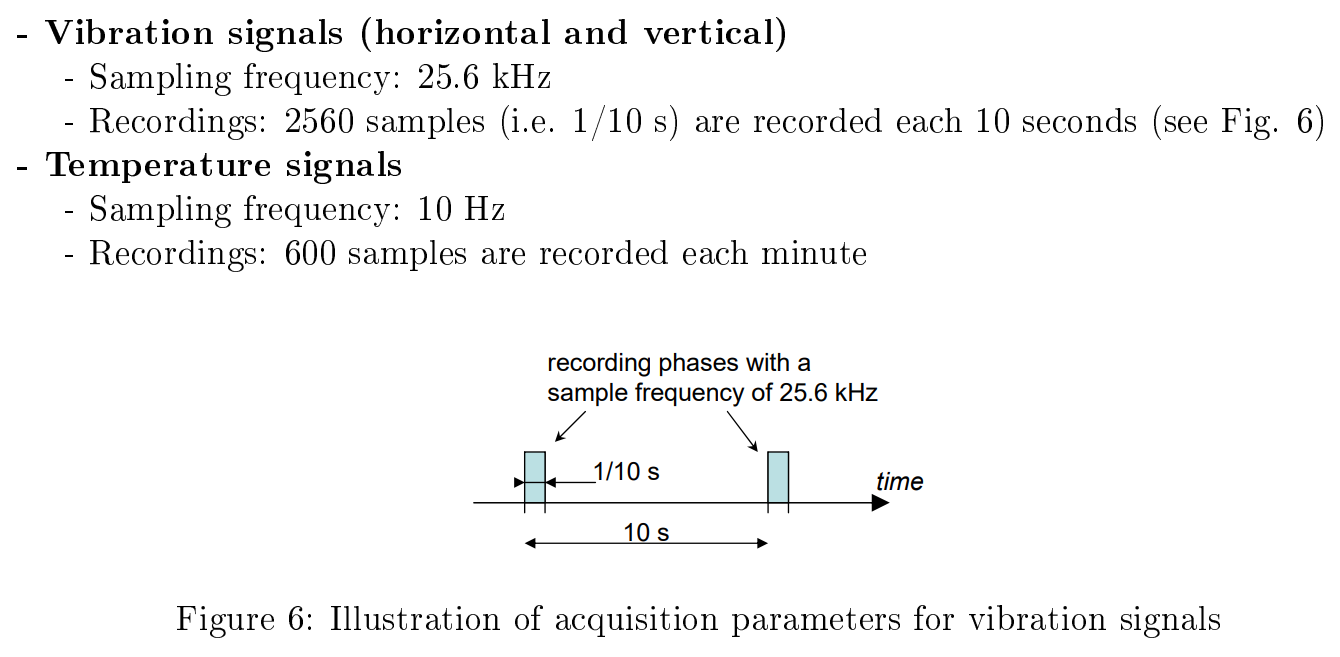

In [ ]:
from natsort import natsorted
file_list = natsorted(glob.glob(os.path.join(DRIVE_FOLDERS['PRONOSTIA'],'Full_Test_Set','Bearing1_3','*')))
#print(*file_list, sep='\n')
print(len(file_list))

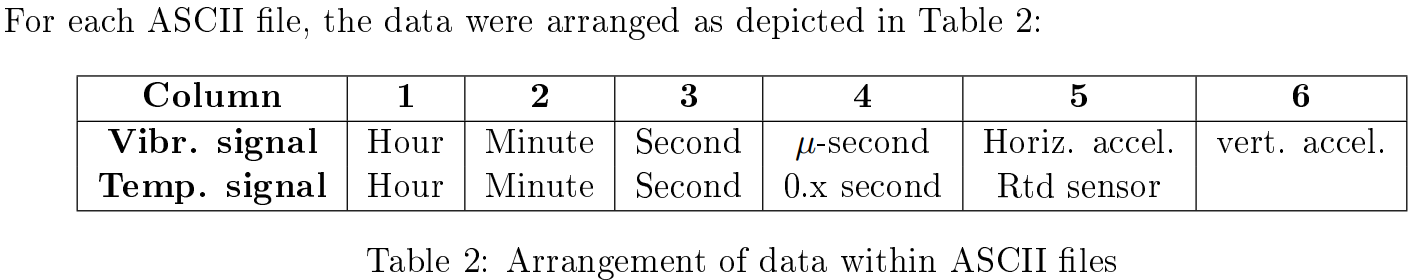

Join all set

The dataset contain:

|Original name |Columns name |
|----|----|
|Hour|hour|
|Minute|min|
|Second|sec|
|$\mu-second $|mi_sec|
|Horizon accel|h_acc|
|Vertial acel|v_acc|

In [ ]:
header = ['hour','min','sec','mi_sec','h_acc','v_acc']
dataframe = []
for data in file_list:
  df = pd.read_csv(data,header=None,names=header)
  dataframe.append(df)
df_bear13 = pd.concat(dataframe)

In [ ]:
df_bear13.reset_index(drop=True, inplace=True)
df_bear13.tail(20)

,hour,min,sec,mi_sec,h_acc,v_acc
6079980,15,8,41,477380.0,-9.083,-4.206
6079981,15,8,41,477420.0,-5.171,-8.121
6079982,15,8,41,477460.0,-13.203,-9.530
6079983,15,8,41,477500.0,-7.301,-8.957
6079984,15,8,41,477540.0,-14.688,-5.154
6079985,15,8,41,477580.0,-13.281,1.766
6079986,15,8,41,477620.0,-11.657,5.057
6079987,15,8,41,477660.0,-15.383,7.788
6079988,15,8,41,477700.0,-3.369,7.986
6079989,15,8,41,477730.0,-14.067,8.826


## Preview data

In [8]:
def mine_naked_preview(df):
  print('\n'.join([
        f'---\/---   Column Name: \n{df.columns}',
        f'---\/---   Describe: \n{df.describe()}',
        f'---\/---   Null value:\n{df.isnull().sum()}',
        f'---\/---   Unique value:\n{df.nunique()}',
        ]))

In [ ]:
mine_naked_preview(df_bear13)

---\/---   Column Name: 
Index(['hour', 'min', 'sec', 'mi_sec', 'h_acc', 'v_acc'], dtype='object')
---\/---   Describe: 
               hour           min           sec        mi_sec         h_acc  \
count  6.080000e+06  6.080000e+06  6.080000e+06  6.080000e+06  6.080000e+06   
mean   1.133937e+01  3.005474e+01  2.598947e+01  4.281439e+05  4.297179e-04   
std    1.932816e+00  1.760422e+01  1.707414e+01  2.886751e+04  1.187043e+00   
min    8.000000e+00  0.000000e+00  1.000000e+00  3.781600e+05 -4.814800e+01   
25%    1.000000e+01  1.500000e+01  1.100000e+01  4.031500e+05 -3.130000e-01   
50%    1.100000e+01  3.100000e+01  2.100000e+01  4.281400e+05  9.000000e-03   
75%    1.300000e+01  4.500000e+01  4.100000e+01  4.531300e+05  3.330000e-01   
max    1.500000e+01  5.900000e+01  5.100000e+01  4.781200e+05  4.812800e+01   

              v_acc  
count  6.080000e+06  
mean   2.442439e-02  
std    1.682963e+00  
min   -4.784300e+01  
25%   -1.930000e-01  
50%    7.200000e-02  
75%    3.6800

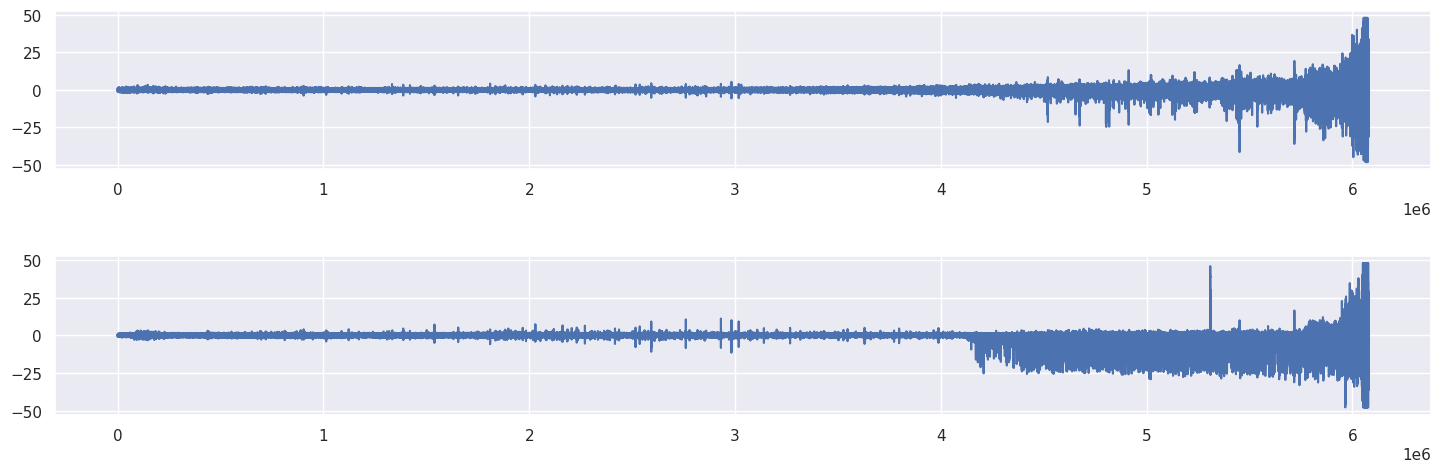

In [ ]:
fig,[ax1,ax2] = plt.subplots(2,1,figsize=(15,5))
ax1.plot(df_bear13['h_acc'])
fig.tight_layout(pad=2)
ax2.plot(df_bear13['v_acc'])

# PRE-PROCESS

## Feature engineering

### functions

In [10]:
import pandas as pd
import numpy as np
### Use for a dataset, like pandas data frame, it will adda column to the data frame
class mine_time_domain:
  ####--------------------------------    MEAN    --------------------------------####
  # Calculate entire data mean
  def pd_mean(self,df,col):
    new_col_name = 'mean_{}'.format(col)
    try:
      df[new_col_name] = df[col].mean()
    except:
      print('Errors in pd_mean!')

    print('-----DONE: pd_mean')
    return df

  # Calculate rolling mean
  def pd_r_mean(self,df,col,window = 3):
    new_col_name = 'r_mean_{}'.format(col)
    try:
        df[new_col_name] = df[col].rolling(window=window,min_periods=1).mean()
    except:
      print('Errors in pd_r_mean!')

    print('-----DONE: pd_r_mean')
    return df

  # Calculate cumulative mean
  def pd_c_mean(self,df,col):
    new_col_name = 'c_mean_{}'.format(col)
    try:
      df[new_col_name] = df[col].cumsum() / (pd.Series(range(1, len(df) + 1)))
    except:
      print('Errors in pd_c_mean!')

    print('-----DONE: pd_c_mean')
    return df

  ####--------------------------------    RMS   --------------------------------####
  # Calculate RMS
  def pd_rms(self,df,col):
    new_col_name = 'rms_{}'.format(col)
    try:
      df[new_col_name] = np.sqrt( (df[col]**2).mean() )
    except:
      print('Errors in pd_rms!')
    print('-----DONE: pd_rms')
    return df

  # Calculate rolling RMS
  def pd_r_rms(self,df,col,window = 3):
    new_col_name = 'r_rms_{}'.format(col)
    try:
      df[new_col_name] = df[col].rolling(window=window,min_periods=1).apply(lambda x: np.sqrt((x**2).mean()), raw=False)
    except:
      print('Errors in pd_r_rms!')
    print('-----DONE: pd_r_rms')
    return df

  # Calculate cumulative RMS - runtime too long: more than 7h (timeout) so ew drop this shits
  # def pd_c_rms(self,df,col):
  #   new_col_name = 'c_rms_{}'.format(col)
  #   try:
  #     df[new_col_name] = df[col].expanding().apply(lambda x: np.sqrt((x**2).mean()), raw=False)
  #   except:
  #     print('Errors in pd_c_mean!')
  #   print('-----DONE: pd_c_rms')
  #   return df

  ####--------------------------------    VARIANCE   --------------------------------####
  # Calculate Cumulative Variance
  def pd_c_var(self,df,col):
    new_col_name = 'c_var_{}'.format(col)
    try:
      df[new_col_name] = df[col].expanding().var()
    except:
      print('Errors in pd_c_mean!')
    print('-----DONE: pd_c_var')
    return df

  # Calculate rolling Variance
  def pd_r_var(self,df,col,window=3):
    new_col_name = 'r_var_{}'.format(col)
    try:
      df[new_col_name] = df[col].rolling(window=window,min_periods=1).var()
    except:
      print('Errors in pd_r_var!')
    print('-----DONE: pd_r_var')
    return df

  ####--------------------------------    KURTOSIS  --------------------------------####
  # Calculate data Kurtosis

  ####--------------------------------    STANDARD DEVIATION  --------------------------------####
  # Calculate rolling standard deviation
  def pd_r_sd(self,df,col,window=3):
    new_col_name = 'r_sd_{}'.format(col)
    df[new_col_name] = df[col].rolling(window=window,min_periods=1).std()
    print('-----DONE: pd_r_sd')
    return df

  # Calculate cumulative standard deviation
  def pd_c_sd(self,df,col):
    new_col_name = 'c_sd_{}'.format(col)
    df[new_col_name] = df[col].expanding().std()
    print('-----DONE: pd_c_sd')
    return df

  ####--------------------------------    SKEWNESS    --------------------------------####
  # Calculate data skewness
  def pd_skewness(self,df,col):
    new_col_name = 'skew_{}'.format(col)
    try:
      df[new_col_name] = df[col].skew()
    except:
      print('Errors in pd_skewness!')

    print('-----DONE: pd_skewness')
    return df

  ####--------------------------------    CREST FACTOR   --------------------------------####
  # Calculate crest factor of x value
  def crest_factor(self,x):
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    return peak / rms
  # Calculate rolling crest factor
  def pd_r_crest(self,df,col,window=3):
    new_col_name = 'r_crest_{}'.format(col)
    try:
      df[new_col_name] = df[col].rolling(window=window,min_periods=1).apply(self.crest_factor, raw=False)
    except:
      print('Errors in pd_r_crest!')

    print('-----DONE: pd_r_crest')
    return df

  # Calculate cumulative crest factor
  def pd_c_crest(self,df,col):
    new_col_name = 'c_crest_{}'.format(col)
    try:
      self.pd_rms(df,col)
      df['c_peak'] = np.abs(df[col]).cummax()
      df[new_col_name] = df['c_peak'] / df['c_rms_{}'.format(col)]
      df.drop('c_peak',axis = 1)
    except:
      print('Errors in pd_c_crest!')
    print('-----DONE: pd_c_crest')
    return df
  ####--------------------------------    AUTO CORRELATION   --------------------------------####
  def pd_ac(self,df,col):
    return df
  ####--------------------------------    ABS - ABSOLUTE VALUE   --------------------------------####
  def pd_abs(self,df,col):
    new_col_name = 'abs_{}'.format(col)
    df[new_col_name] = df[col].abs()
    print('-----DONE: pd_abs')
    return df
  ####--------------------------------    ALL FEATURES    --------------------------------####
  def pd_allfeature(self,df,col,window = 3, plot_all = True):
    ###------###  MEAN  ###------###
    #self.pd_mean(df,col)
    self.pd_r_mean(df,col,window)
    self.pd_c_mean(df,col)
    ###------###  RMS  ###------###
    #self.pd_rms(df,col)
    self.pd_r_rms(df,col,window)
    #self.pd_c_rms(df,col)
    ###------###  VARIANCE  ###------###
    self.pd_r_var(df,col,window)
    self.pd_c_var(df,col)
    ###------###  STANDARD DEVIATION  ###------###
    self.pd_r_sd(df,col,window)
    self.pd_c_sd(df,col)
    ###------###  SKEWNESS  ###------###
    #self.pd_skewness(df,col)
    ###------###  CREST FACTOR  ###------###
    #self.pd_r_crest(df,col,window)
    #self.pd_c_crest(df,col)

    # Plot all out if wanted
    if plot_all == True:
      df.plot(subplots = True,layout=(5,6),figsize=(15,15))

Drop the time

In [ ]:
df_bear13 = df_bear13.drop(['hour','min','sec','mi_sec'],axis =1)
df_bear13.columns

### TIME DOMAINS
Make the data positive
The frequency data variate around 0, so when calculte mean it aslo variate around 0 -> so we `abs()` it

In [11]:
time_domain = mine_time_domain()

In [ ]:
time_domain.pd_abs(df = df_bear13, col = 'h_acc')

-----DONE: pd_abs


,h_acc,v_acc,abs_h_acc
0,0.092,0.044,0.092
1,-0.025,0.432,0.025
2,-0.104,0.008,0.104
3,0.056,-0.264,0.056
4,0.074,-0.195,0.074
...,...,...,...
6079995,33.903,-1.528,33.903
6079996,25.437,-3.536,25.437
6079997,23.199,0.278,23.199
6079998,17.238,2.507,17.238


In [12]:
time_domain.pd_allfeature(df = df_bear13, col = 'v_acc',window = 100,plot_all = False)

-----DONE: pd_r_mean
-----DONE: pd_c_mean
-----DONE: pd_r_rms
-----DONE: pd_r_var
-----DONE: pd_c_var
-----DONE: pd_r_sd
-----DONE: pd_c_sd
-----DONE: pd_skewness


In [27]:
len(df_bear13.columns)

10

In [45]:
file_save_feature = mine_save_newthing(PRONOSTIA['SAVE_DATA'] ,file_name = 'bear13_feature.csv')
df_bear13.to_csv(file_save_feature,index=False)

-File will save as: 2023_06_27_bear13_feature.csv
-Path to file: /content/drive/MyDrive/ColabProjects/PdM/dataset/Pronostia/features/bear13_feature/2023_06_27_bear13_feature.csv


### features

Load if fail to run

In [9]:
loaded = mine_load_newthing(os.path.join(PRONOSTIA['SAVE_DATA'],'bear13_feature'))
df_bear13 = pd.read_csv(loaded)

number 0: 2023_06_27_bear13_feature.csv
number 1: 2023_06_26_bear13_feature.csv
-------> Model path choose: /content/drive/MyDrive/ColabProjects/PdM/dataset/Pronostia/features/bear13_feature/2023_06_27_bear13_feature.csv


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

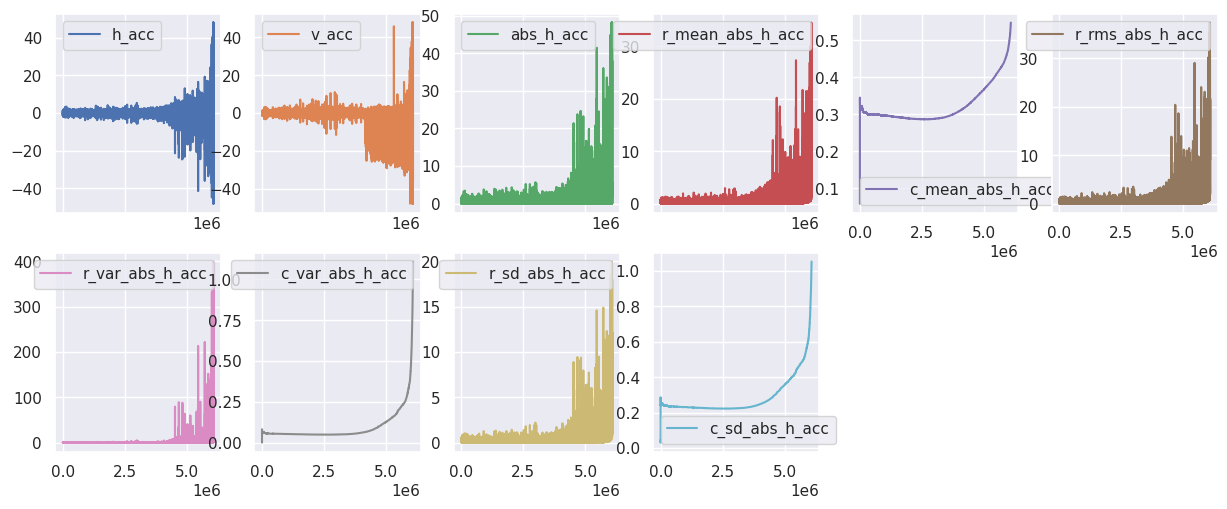

In [25]:
df_bear13.plot(subplots = True,layout = (5,6), figsize = (15,15))

In [39]:
df_bear13 = df_bear13.drop(['level_0'],axis = 1)

In [44]:
mine_naked_preview(df_bear13)

---\/---   Column Name: 
Index(['index', 'h_acc', 'v_acc', 'abs_h_acc', 'r_mean_abs_h_acc',
       'c_mean_abs_h_acc', 'r_rms_abs_h_acc', 'r_var_abs_h_acc',
       'c_var_abs_h_acc', 'r_sd_abs_h_acc', 'c_sd_abs_h_acc', 'MAX', 'RUL',
       'HI'],
      dtype='object')
---\/---   Describe: 
              index         h_acc         v_acc     abs_h_acc  \
count  6.079999e+06  6.079999e+06  6.079999e+06  6.079999e+06   
mean   3.039999e+06  4.297029e-04  2.442438e-02  5.474327e-01   
std    1.755145e+06  1.187043e+00  1.682963e+00  1.053275e+00   
min    0.000000e+00 -4.814800e+01 -4.784300e+01  0.000000e+00   
25%    1.520000e+06 -3.130000e-01 -1.930000e-01  1.480000e-01   
50%    3.039999e+06  9.000000e-03  7.200000e-02  3.230000e-01   
75%    4.559998e+06  3.330000e-01  3.680000e-01  6.010000e-01   
max    6.079998e+06  4.812800e+01  4.784900e+01  4.814800e+01   

       r_mean_abs_h_acc  c_mean_abs_h_acc  r_rms_abs_h_acc  r_var_abs_h_acc  \
count      6.079999e+06      6.079999e+06   

Drop the first row beacause it NaN

In [24]:
df_bear13.dropna(inplace=True)
df_bear13

,h_acc,v_acc,abs_h_acc,r_mean_abs_h_acc,c_mean_abs_h_acc,r_rms_abs_h_acc,r_var_abs_h_acc,c_var_abs_h_acc,r_sd_abs_h_acc,c_sd_abs_h_acc
1,-0.025,0.432,0.025,0.058500,0.058500,0.067413,0.002244,0.002244,0.047376,0.047376
2,-0.104,0.008,0.104,0.073667,0.073667,0.081456,0.001812,0.001812,0.042572,0.042572
3,0.056,-0.264,0.056,0.069250,0.069250,0.075896,0.001286,0.001286,0.035864,0.035864
4,0.074,-0.195,0.074,0.070200,0.070200,0.075521,0.000969,0.000969,0.031132,0.031132
5,-0.147,-0.373,0.147,0.083000,0.083000,0.091402,0.001758,0.001758,0.041933,0.041933
...,...,...,...,...,...,...,...,...,...,...
6079995,33.903,-1.528,33.903,16.284100,0.547421,19.009155,106.862301,1.109153,10.337422,1.053163
6079996,25.437,-3.536,25.437,17.662100,0.547425,20.309198,111.681932,1.109255,10.567967,1.053212
6079997,23.199,0.278,23.199,18.443700,0.547429,21.038517,113.832374,1.109339,10.669226,1.053252
6079998,17.238,2.507,17.238,19.830600,0.547432,21.707120,86.607065,1.109385,9.306292,1.053273


## Create RUL - HI target

Since the whole dataset it take from start to end. We will use the index value as cycles, and use it to calculate RUL (and HI)


In [ ]:
def add_rul(df):
  df_rul = df.copy()
  # Get the total number of cycles
  df_rul['MAX'] = len(df_rul)
  try:
      df_rul.reset_index(inplace=True)
  except:
    None
  # Calculate remaining useful life for each row
  remaining_useful_life = df_rul["MAX"] - df_rul["index"]
  df_rul["RUL"] = remaining_useful_life
  # Add HI
  df_rul['HI'] = (remaining_useful_life / df_rul['MAX']) * 100
  return df_rul

# The mode is define in global varible, in 'FOLDER PATHS'
df_bear13 = add_rul(df_bear13)
df_bear13.tail(15)

In [13]:
df_bear13.head(10)

,index,h_acc,v_acc,abs_h_acc,r_mean_abs_h_acc,c_mean_abs_h_acc,r_rms_abs_h_acc,r_var_abs_h_acc,c_var_abs_h_acc,r_sd_abs_h_acc,c_sd_abs_h_acc,MAX,RUL,HI
0,0,-0.025,0.432,0.025,0.058500,0.058500,0.067413,0.002244,0.002244,0.047376,0.047376,6079999,6079999,100.000000
1,1,-0.104,0.008,0.104,0.073667,0.073667,0.081456,0.001812,0.001812,0.042572,0.042572,6079999,6079998,99.999984
2,2,0.056,-0.264,0.056,0.069250,0.069250,0.075896,0.001286,0.001286,0.035864,0.035864,6079999,6079997,99.999967
3,3,0.074,-0.195,0.074,0.070200,0.070200,0.075521,0.000969,0.000969,0.031132,0.031132,6079999,6079996,99.999951
4,4,-0.147,-0.373,0.147,0.083000,0.083000,0.091402,0.001758,0.001758,0.041933,0.041933,6079999,6079995,99.999934
5,5,-0.237,-0.130,0.237,0.105000,0.105000,0.123227,0.004853,0.004853,0.069666,0.069666,6079999,6079994,99.999918
6,6,-0.114,0.497,0.114,0.106125,0.106125,0.122112,0.004170,0.004170,0.064577,0.064577,6079999,6079993,99.999901
7,7,-0.252,-0.128,0.252,0.122333,0.122333,0.142515,0.006013,0.006013,0.077545,0.077545,6079999,6079992,99.999885
8,8,-0.865,0.378,0.865,0.196600,0.196600,0.305126,0.060500,0.060500,0.245968,0.245968,6079999,6079991,99.999868
9,9,-0.714,0.882,0.714,0.258800,0.243636,0.378464,0.084731,0.078787,0.291086,0.280690,6079999,6079990,99.999852


Add non linear HI

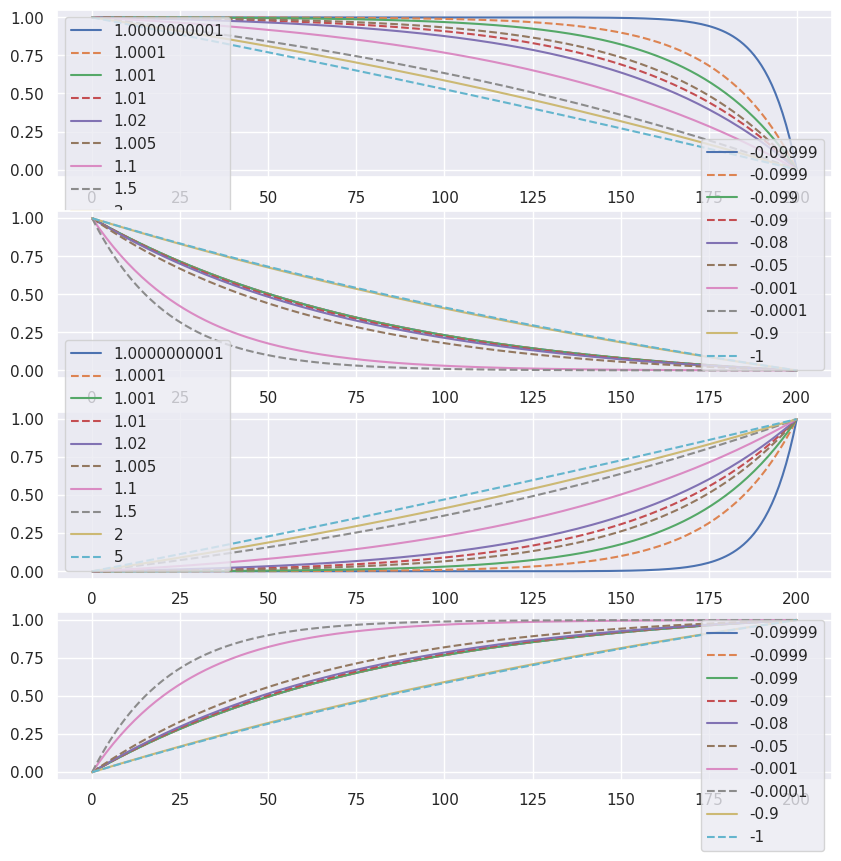

In [19]:
# Show how such function run with each c
fig ,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,10))

T=200
t = np.linspace(0,200,200)
c_up = [1.0000000001, 1.0001, 1.001, 1.01, 1.02, 1.005, 1.1, 1.5, 2, 5  ]
c_down = [-0.09999, -0.09990, -0.09900, -0.09000, -0.08, -0.05, -0.001, -0.0001,-0.9, -1]
for i in range(0,10):
  linestyle = '-' if i % 2 == 0 else '--'

  HI_up = (1 - c_up[i]) * ((0 - c_up[i])/(1 - c_up[i]))**(t/T) + c_up[i]
  ax1.plot(t,HI_up,linestyle=linestyle, label = '{}'.format(c_up[i]))

  HI_down = (1 - c_down[i]) * ((0 - c_down[i])/(1 - c_down[i]))**(t/T) + c_down[i]
  ax2.plot(t,HI_down, linestyle=linestyle, label = '{}'.format(c_down[i]))

  HI_up_inver = 1 - HI_up
  ax3.plot(t,HI_up_inver,linestyle=linestyle, label = '{}'.format(c_up[i]))

  HI_down_inver = 1 - HI_down
  ax4.plot(t,HI_down_inver,linestyle=linestyle, label = '{}'.format(c_down[i]))

  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()

In [25]:
def add_nonL_HI(df,c = 1.02):
  # Get the total number of cycles for each unit
    result_frame = df.copy()
    result_frame['MAX'] = len(df)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["MAX"] - result_frame["index"]
    result_frame["RUL"] = remaining_useful_life
    # Add HI
    result_frame['HI'] = 1 - ((1 - c) * ((0-c)/(1-c))**((result_frame["index"])/ result_frame["MAX"]) + c)


    # Drop MAX and RUL
    result_frame= result_frame.drop(['RUL','MAX'],axis=1)
    return result_frame
df_bear13 = add_nonL_HI(df_bear13,c = (1 + 10**(-10)))

<Axes: xlabel='index'>

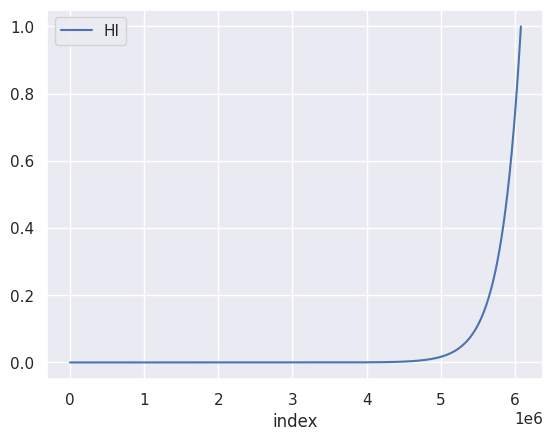

In [27]:
df_bear13.plot('index','HI')

# FORMAT IN-OUT